# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


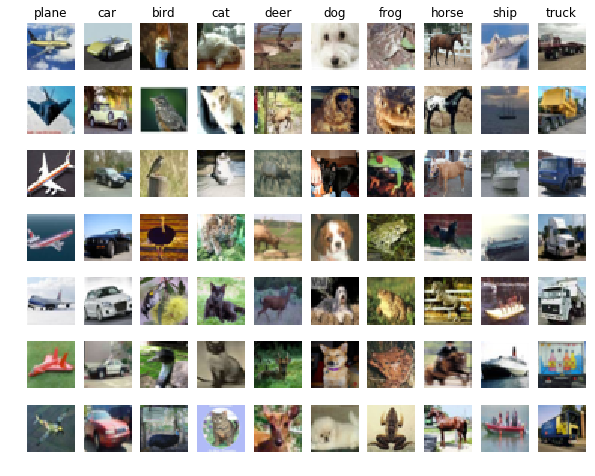

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


shape of mean_image:  (3072,)
[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


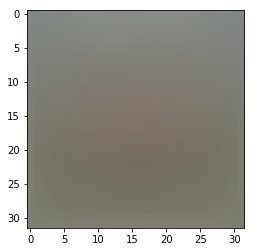

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print("shape of mean_image: ", mean_image.shape)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
# W = np.zeros([3073, 10])
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.503871


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print("check the regularizaiton's gradient: ")
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 4.283929 analytic: 4.283929, relative error: 7.340220e-11
numerical: 0.377356 analytic: 0.377356, relative error: 1.157522e-10
numerical: -2.247953 analytic: -2.247953, relative error: 7.039159e-11
numerical: -19.687816 analytic: -19.579677, relative error: 2.753902e-03
numerical: -1.923284 analytic: -1.923284, relative error: 2.014093e-10
numerical: 30.433556 analytic: 30.542187, relative error: 1.781534e-03
numerical: 3.461776 analytic: 3.472773, relative error: 1.585848e-03
numerical: 2.044068 analytic: 2.044068, relative error: 1.648387e-11
numerical: 0.999116 analytic: 0.999116, relative error: 7.368356e-11
numerical: 6.334304 analytic: 6.334304, relative error: 2.622258e-11
check the regularizaiton's gradient: 
numerical: 16.891069 analytic: 16.888280, relative error: 8.257896e-05
numerical: 2.685893 analytic: 2.685893, relative error: 3.386952e-11
numerical: 7.514645 analytic: 7.514645, relative error: 1.988922e-11
numerical: 31.099827 analytic: 31.213515, relative er

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

The max operation technically make the loss function non-differentiable because at the kinks the gradient is not defined.When the ckecking point at the kinks (or very close to the kinks), the centered difference used by the numerical gradient is not what we used in the analytical gradient.

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.503871e+00 computed in 0.084656s
Vectorized loss: 8.503871e+00 computed in 0.080967s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.081663s
Vectorized loss and gradient: computed in 0.000000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [20]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=2000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 2000: loss 793.089295
iteration 200 / 2000: loss 287.878212
iteration 400 / 2000: loss 106.910640
iteration 600 / 2000: loss 42.506884
iteration 800 / 2000: loss 18.743308
iteration 1000 / 2000: loss 10.412081
iteration 1200 / 2000: loss 7.224995
iteration 1400 / 2000: loss 6.105082
iteration 1600 / 2000: loss 5.908901
iteration 1800 / 2000: loss 5.817322
That took 10.844337s


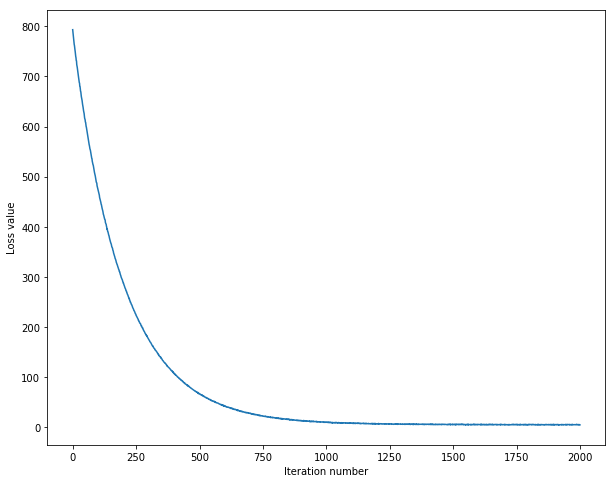

In [21]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [22]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print("y_train: {}, min/max y_train: {} {}".format(y_train, np.min(y_train), np.max(y_train)))
print("y_train_pred: {}, min/max y_train_pred: {} {}".format(y_train_pred, np.min(y_train_pred), np.max(y_train_pred)))
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

y_train: [6 9 9 ..., 4 9 3], min/max y_train: 0 9
y_train_pred: [6 1 9 ..., 4 6 8], min/max y_train_pred: 0 9
training accuracy: 0.383429
validation accuracy: 0.396000


In [24]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
import math
max_count = 100
for count in range(max_count):
    
    lr = 10**np.random.uniform(math.log10(learning_rates[0]), math.log10(learning_rates[1]))
    reg = 10**np.random.uniform(math.log10(regularization_strengths[0]), math.log10(regularization_strengths[1]))
    print("iter: {}: lr = {}, reg = {}".format(count, lr, reg))
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=2000, verbose=True)
    y_train_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_train_pred == y_train)
    y_val_pred = svm.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = svm
    results[(lr,reg)] = (train_accuracy, val_accuracy)

                           
# pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iter: 0: lr = 3.4679297207550574e-05, reg = 41745.67722118332
iteration 0 / 2000: loss 1308.240290
iteration 200 / 2000: loss 2057.450671
iteration 400 / 2000: loss 2107.711107
iteration 600 / 2000: loss 1804.223100
iteration 800 / 2000: loss 1861.430750
iteration 1000 / 2000: loss 1626.716222
iteration 1200 / 2000: loss 1968.161271
iteration 1400 / 2000: loss 1837.603448
iteration 1600 / 2000: loss 1954.862339
iteration 1800 / 2000: loss 1605.188876
iter: 1: lr = 1.0680239928121881e-07, reg = 40677.844455071056
iteration 0 / 2000: loss 1297.766506
iteration 200 / 2000: loss 226.320560
iteration 400 / 2000: loss 43.861209
iteration 600 / 2000: loss 12.337788
iteration 800 / 2000: loss 6.731499
iteration 1000 / 2000: loss 5.725326
iteration 1200 / 2000: loss 5.716027
iteration 1400 / 2000: loss 5.934766
iteration 1600 / 2000: loss 5.725678
iteration 1800 / 2000: loss 5.722064
iter: 2: lr = 4.7351115948896295e-06, reg = 29029.04392537143
iteration 0 / 2000: loss 911.507098
iteration 200 

iteration 1600 / 2000: loss 761.603729
iteration 1800 / 2000: loss 389.089493
iter: 19: lr = 4.5822264834280044e-06, reg = 38630.080224901285
iteration 0 / 2000: loss 1204.105207
iteration 200 / 2000: loss 21.600980
iteration 400 / 2000: loss 18.475911
iteration 600 / 2000: loss 19.914958
iteration 800 / 2000: loss 26.631021
iteration 1000 / 2000: loss 15.739377
iteration 1200 / 2000: loss 19.961657
iteration 1400 / 2000: loss 21.351143
iteration 1600 / 2000: loss 23.229803
iteration 1800 / 2000: loss 18.380916
iter: 20: lr = 2.4674200200661055e-06, reg = 37626.35689291991
iteration 0 / 2000: loss 1188.981427
iteration 200 / 2000: loss 10.920264
iteration 400 / 2000: loss 14.934737
iteration 600 / 2000: loss 13.195965
iteration 800 / 2000: loss 10.513993
iteration 1000 / 2000: loss 21.154084
iteration 1200 / 2000: loss 12.295291
iteration 1400 / 2000: loss 10.481903
iteration 1600 / 2000: loss 12.050198
iteration 1800 / 2000: loss 13.852657
iter: 21: lr = 3.2568070835568635e-06, reg = 

iteration 1000 / 2000: loss 5.118387
iteration 1200 / 2000: loss 5.717368
iteration 1400 / 2000: loss 5.248561
iteration 1600 / 2000: loss 5.434353
iteration 1800 / 2000: loss 4.916202
iter: 38: lr = 8.20077746058088e-06, reg = 37532.66669140106
iteration 0 / 2000: loss 1196.960417
iteration 200 / 2000: loss 37.898786
iteration 400 / 2000: loss 31.270451
iteration 600 / 2000: loss 45.491134
iteration 800 / 2000: loss 44.018126
iteration 1000 / 2000: loss 37.199403
iteration 1200 / 2000: loss 48.813762
iteration 1400 / 2000: loss 48.029049
iteration 1600 / 2000: loss 44.226269
iteration 1800 / 2000: loss 44.672783
iter: 39: lr = 4.160642054639318e-05, reg = 40324.37642008849
iteration 0 / 2000: loss 1261.668267
iteration 200 / 2000: loss 6281.636062
iteration 400 / 2000: loss 6777.663536
iteration 600 / 2000: loss 6191.889103
iteration 800 / 2000: loss 6147.462497
iteration 1000 / 2000: loss 6807.835612
iteration 1200 / 2000: loss 6221.153440
iteration 1400 / 2000: loss 6764.477848
iter

iteration 400 / 2000: loss 11.945868
iteration 600 / 2000: loss 13.041744
iteration 800 / 2000: loss 12.002793
iteration 1000 / 2000: loss 12.611851
iteration 1200 / 2000: loss 14.536119
iteration 1400 / 2000: loss 14.506994
iteration 1600 / 2000: loss 15.164529
iteration 1800 / 2000: loss 14.777126
iter: 57: lr = 1.202804523639161e-06, reg = 42523.69709713326
iteration 0 / 2000: loss 1334.257890
iteration 200 / 2000: loss 8.035608
iteration 400 / 2000: loss 8.148665
iteration 600 / 2000: loss 9.147588
iteration 800 / 2000: loss 9.084049
iteration 1000 / 2000: loss 7.987726
iteration 1200 / 2000: loss 8.402101
iteration 1400 / 2000: loss 9.119571
iteration 1600 / 2000: loss 6.875520
iteration 1800 / 2000: loss 8.882169
iter: 58: lr = 1.3861673121841896e-06, reg = 39046.85847536791
iteration 0 / 2000: loss 1229.950550
iteration 200 / 2000: loss 6.712018
iteration 400 / 2000: loss 7.772952
iteration 600 / 2000: loss 8.539244
iteration 800 / 2000: loss 8.478360
iteration 1000 / 2000: loss

iteration 400 / 2000: loss 170.211069
iteration 600 / 2000: loss 230.609003
iteration 800 / 2000: loss 261.457075
iteration 1000 / 2000: loss 181.296864
iteration 1200 / 2000: loss 159.080774
iteration 1400 / 2000: loss 223.429862
iteration 1600 / 2000: loss 180.001780
iteration 1800 / 2000: loss 194.283402
iter: 76: lr = 2.2226410433085413e-05, reg = 26855.254212512617
iteration 0 / 2000: loss 849.625387
iteration 200 / 2000: loss 176.323137
iteration 400 / 2000: loss 162.847601
iteration 600 / 2000: loss 205.067129
iteration 800 / 2000: loss 225.743711
iteration 1000 / 2000: loss 176.001145
iteration 1200 / 2000: loss 161.336043
iteration 1400 / 2000: loss 214.928273
iteration 1600 / 2000: loss 174.019693
iteration 1800 / 2000: loss 147.284096
iter: 77: lr = 1.9170261158800448e-05, reg = 31524.80449889084
iteration 0 / 2000: loss 992.176657
iteration 200 / 2000: loss 196.256815
iteration 400 / 2000: loss 182.756462
iteration 600 / 2000: loss 173.612625
iteration 800 / 2000: loss 180.

iteration 200 / 2000: loss 6.427391
iteration 400 / 2000: loss 5.982600
iteration 600 / 2000: loss 5.841917
iteration 800 / 2000: loss 6.643380
iteration 1000 / 2000: loss 5.806253
iteration 1200 / 2000: loss 6.065130
iteration 1400 / 2000: loss 5.487149
iteration 1600 / 2000: loss 5.790014
iteration 1800 / 2000: loss 6.711497
iter: 95: lr = 7.129450368040174e-07, reg = 49864.98461235311
iteration 0 / 2000: loss 1552.711926
iteration 200 / 2000: loss 6.700814
iteration 400 / 2000: loss 7.105771
iteration 600 / 2000: loss 7.168525
iteration 800 / 2000: loss 6.742952
iteration 1000 / 2000: loss 6.268076
iteration 1200 / 2000: loss 6.159602
iteration 1400 / 2000: loss 7.343963
iteration 1600 / 2000: loss 6.238709
iteration 1800 / 2000: loss 6.819602
iter: 96: lr = 2.0406264089507213e-06, reg = 32311.601985730427
iteration 0 / 2000: loss 1023.184097
iteration 200 / 2000: loss 9.797409
iteration 400 / 2000: loss 10.632750
iteration 600 / 2000: loss 9.288790
iteration 800 / 2000: loss 11.603

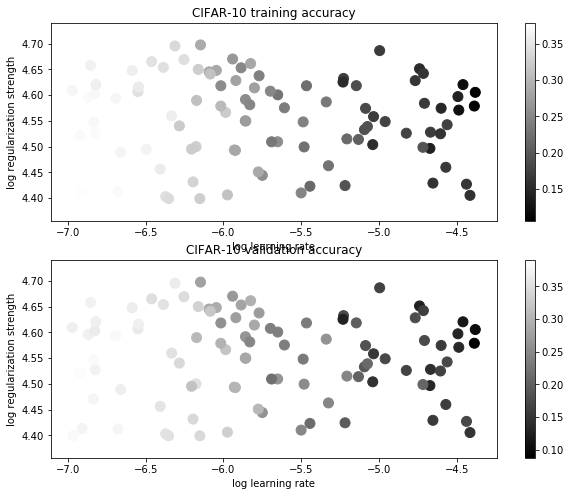

In [25]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [26]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.371000


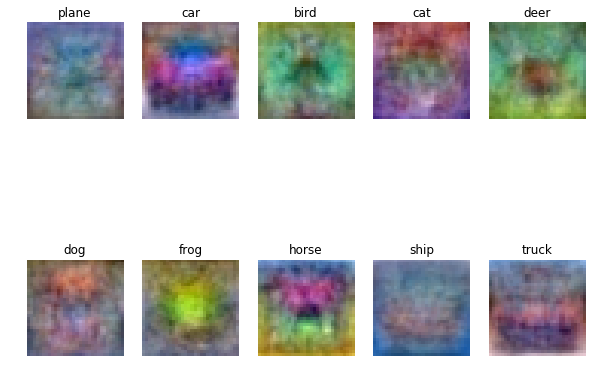

In [27]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *They look like special color blobs whose shapes and colors are mixture or overlapping of their own training images.*